In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Data analys and plot

In [2]:
dataset = pd.read_csv("headbrain.csv")

In [3]:
print(*dataset.shape)
dataset.head()

237 4


,Gender,Age Range,Head Size(cm^3),Brain Weight(grams)
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Gender               237 non-null    int64
 1   Age Range            237 non-null    int64
 2   Head Size(cm^3)      237 non-null    int64
 3   Brain Weight(grams)  237 non-null    int64
dtypes: int64(4)
memory usage: 7.5 KB


In [5]:
dataset.isnull().any()

Gender                 False
Age Range              False
Head Size(cm^3)        False
Brain Weight(grams)    False
dtype: bool

In [6]:
dataset.nunique()

# dataset.family.unique()

Gender                   2
Age Range                2
Head Size(cm^3)        221
Brain Weight(grams)    146
dtype: int64

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

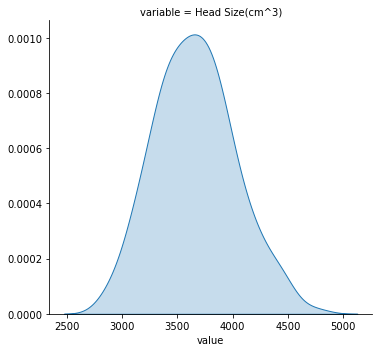

In [8]:
df = pd.melt(train_dataset, 'Brain Weight(grams)', "Head Size(cm^3)")  # train_dataset.columns[-1], train_dataset.columns[-2]

g = sns.FacetGrid(df, col="variable", col_wrap=2, height=5)  #  hue="species", 
g.map(sns.kdeplot, "value", shade=True)

plt.show()

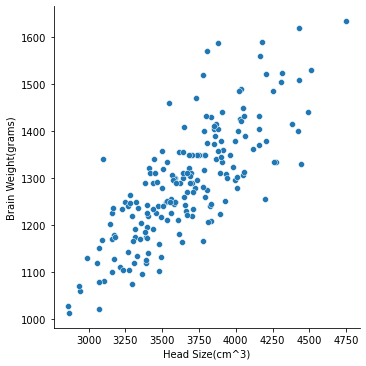

In [9]:
sns.relplot(x=train_dataset.iloc[:, -2], y=train_dataset.iloc[:, -1])

In [10]:
train_stats = train_dataset.iloc[:, -2:]
train_stats = train_stats.describe().T
train_stats

,count,mean,std,min,25%,50%,75%,max
Head Size(cm^3),190.0,3659.126316,362.904851,2857.0,3395.25,3647.5,3887.0,4747.0
Brain Weight(grams),190.0,1288.863158,122.443950,1012.0,1212.00,1290.0,1356.5,1635.0


In [11]:
# X = train_dataset.copy()
# Y = test_dataset.copy()

train_labels = train_dataset["Head Size(cm^3)"]  # .pop("Head Size(cm^3)")
test_labels = test_dataset["Head Size(cm^3)"]  # .pop("Head Size(cm^3)")

<!-- ### Normalize the data 
<center> $ x_{norm} = {(x - x^{train}_{\mu}) \over x^{train}_{\sigma} } $ <center> -->

In [12]:
# def norm(x):
#     stats = X.describe().T
#     return (x - stats['mean']) / stats['std']
#
# x_norm = norm(X)
# y_norm = norm(Y)
brain_weight = np.array(train_dataset["Brain Weight(grams)"])
brain_weight_norm = preprocessing.Normalization(input_shape=[1,])
brain_weight_norm.adapt(brain_weight)

# Model

In [13]:
brain_weight_model = keras.Sequential([
    brain_weight_norm,
    layers.Dense(units=3),
#     layers.Dense(units=10),
    layers.Dense(1)
])

brain_weight_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 3)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 13
Trainable params: 10
Non-trainable params: 3
_________________________________________________________________


In [14]:
brain_weight_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.3),
    loss='mae')

In [15]:
%%time
history = brain_weight_model.fit(
    train_dataset["Brain Weight(grams)"], train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

Wall time: 1.99 s


In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
45,173.176453,177.718292,45
46,172.764648,176.218231,46
47,172.540894,174.388184,47
48,172.633224,172.619858,48
49,171.910080,174.255188,49


with 1 hidden layer (3 units), lr = 1: 176.711197	177.528580  
with 1 hidden layer (3 units), lr = 0.3: 171.564560	173.035248  
with 2 hidden layer (3, 10 units), lr = 0.3: 197.403152	189.431549  
with 2 hidden layer (3, 10 units), lr = 1: 211.929810	223.222916

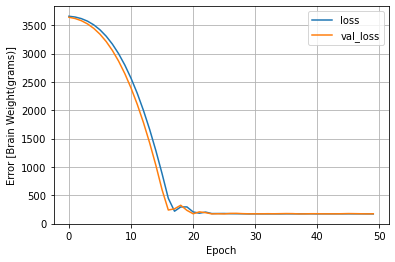

In [17]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
#     plt.ylim([0, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Brain Weight(grams)]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [18]:
test_results = {}

test_results["Brain Weight(grams)"] = brain_weight_model.evaluate(
    train_dataset["Brain Weight(grams)"],
    train_labels, verbose=0)

print(test_results["Brain Weight(grams)"], history.history['loss'][-1], history.history['val_loss'][-1])

172.19688415527344 171.9100799560547 174.25518798828125


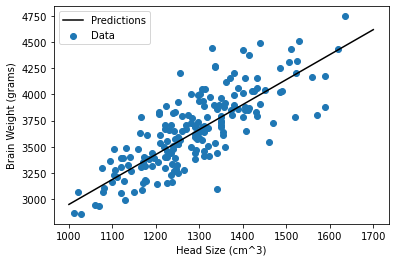

In [19]:
x = tf.linspace(1000., 1700, 500)
y = brain_weight_model.predict(x)

def plot_brain_weight(x, y):
    plt.scatter(train_dataset["Brain Weight(grams)"], train_labels, label="Data")
    plt.plot(x, y, color='k', label='Predictions')
#     plt.ylim([0, 5000])
    plt.xlabel('Head Size (cm^3)')
    plt.ylabel('Brain Weight (grams)')
    plt.legend()

plot_brain_weight(x, y)

# MSE

In [20]:
brain_weight_model = keras.Sequential([
    brain_weight_norm,
    layers.Dense(units=3),
    layers.Dense(1)])

# brain_weight_model.summary()

brain_weight_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.3),
    loss='mse')


history = brain_weight_model.fit(
    train_dataset["Brain Weight(grams)"], train_labels,
    epochs=50,
    verbose=0,
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
# hist.tail()

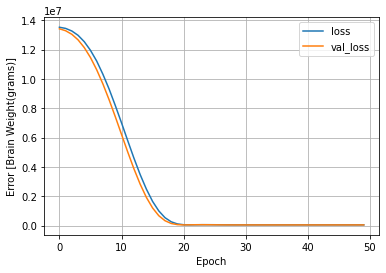

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
#     plt.ylim([0, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Brain Weight(grams)]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

222.81026471529538 224.05428855246222 217.8138898807879


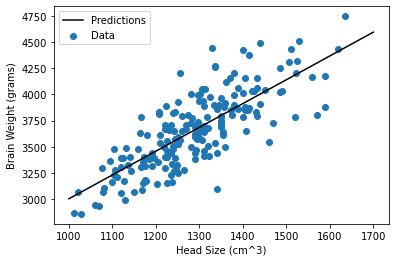

In [22]:
test_results = {}

test_results["Brain Weight(grams)"] = brain_weight_model.evaluate(
    train_dataset["Brain Weight(grams)"],
    train_labels, verbose=0)

print(np.sqrt(test_results["Brain Weight(grams)"]), 
      np.sqrt(history.history['loss'][-1]), 
      np.sqrt(history.history['val_loss'][-1]))

x = tf.linspace(1000., 1700, 500)
y = brain_weight_model.predict(x)

def plot_brain_weight(x, y):
    plt.scatter(train_dataset["Brain Weight(grams)"], train_labels, label="Data")
    plt.plot(x, y, color='k', label='Predictions')
#     plt.ylim([0, 5000])
    plt.xlabel('Head Size (cm^3)')
    plt.ylabel('Brain Weight (grams)')
    plt.legend()

plot_brain_weight(x, y)